In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

from fastprogress import progress_bar

import jlinops
import sampi

from fastprogress import progress_bar
import rasterio
from rasterio.plot import show


# Plot baseline

In [4]:
fp = r'sea_ice_subset_2.tif'
r_img = rasterio.open(fp)
tmp = r_img.read(1)**2 + r_img.read(2)**2
top_quantile = np.quantile(tmp.flatten(), 0.99)
clipped_img = np.clip(tmp, a_max=top_quantile, a_min=None)
full_img = (clipped_img/np.amax(clipped_img)) + 1e-6

Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [94]:
fp = r'sea_ice_subset_2_refined_lee.tif'
r_img = rasterio.open(fp)
tmp = r_img.read(1)
top_quantile = np.quantile(tmp.flatten(), 0.99)
bottom_quantile = np.quantile(tmp.flatten(), 0.01)
clipped_img = np.clip(tmp, a_max=top_quantile, a_min=bottom_quantile)

full_img_lee = (clipped_img/np.amax(clipped_img)) + 1e-1
full_img_lee = full_img_lee[:1000,:1000]

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored


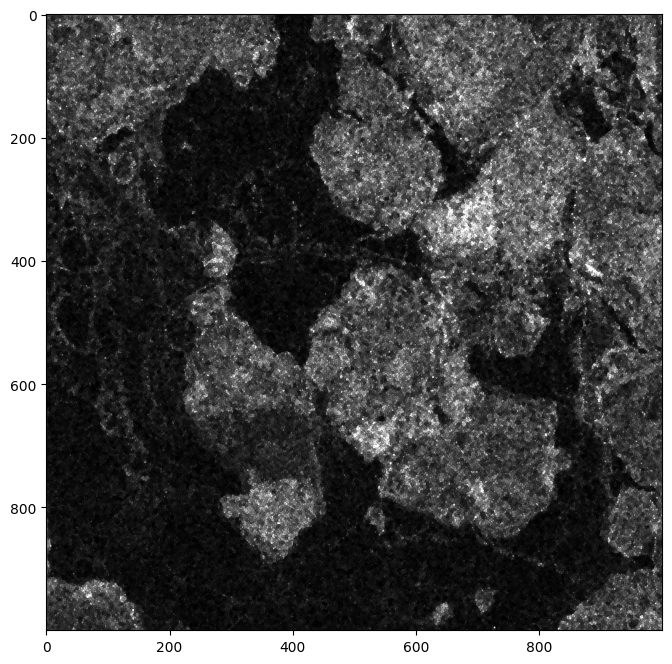

In [95]:
plt.figure(figsize=(13,8))
plt.imshow(full_img_lee, cmap="gray")
plt.show()

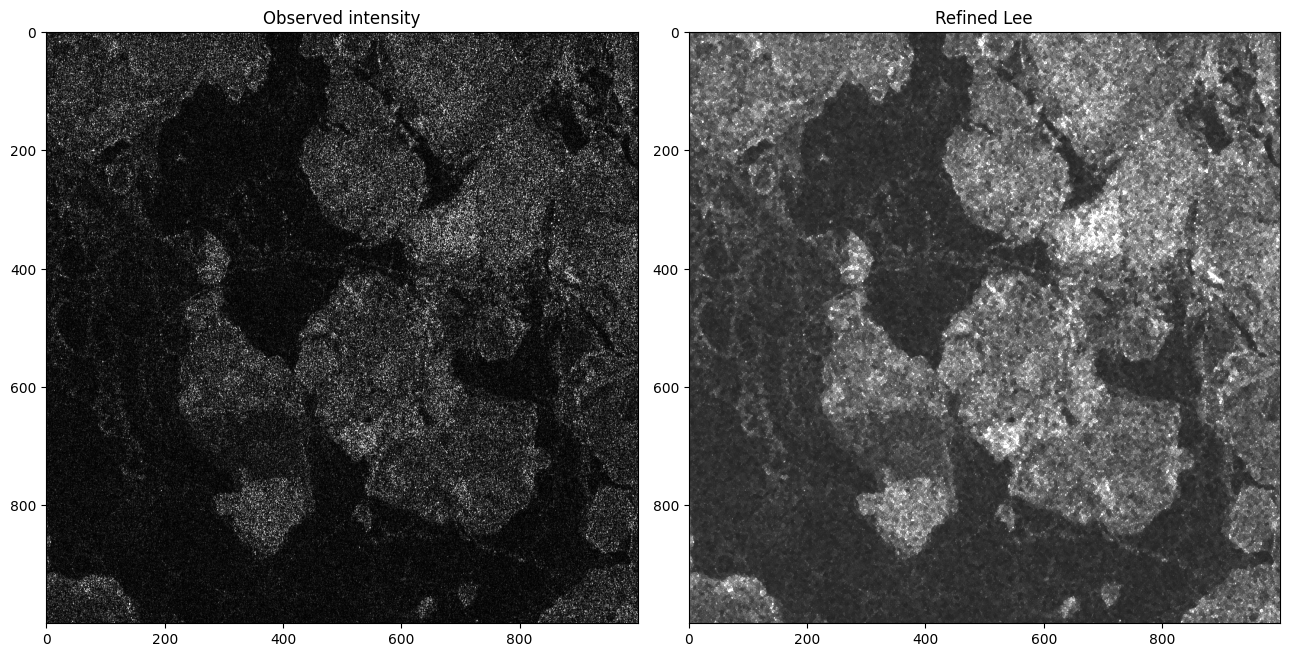

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].imshow(full_img[:1000,:1000], cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Observed intensity")

axs[1].imshow(full_img_lee, cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Refined Lee")

fig.tight_layout()

#fig.savefig("despeckling_refined_lee_real_example.png", dpi=250, bbox_inches='tight')

plt.show()

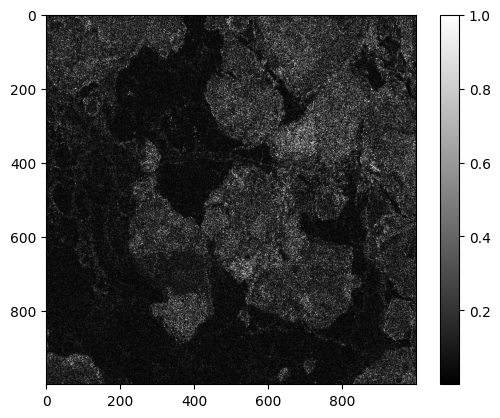

In [97]:
plt.imshow(full_img[:1000,:1000], cmap="gray")
plt.colorbar()
plt.show()

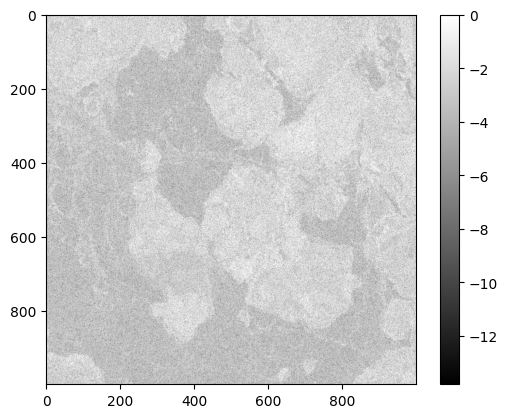

In [98]:
plt.imshow(np.log(full_img[:1000,:1000]), cmap="gray")
plt.colorbar()
plt.show()

# Log solver

In [76]:

class LogDespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, R, y, hyperparams, L=1, pdata={}):

        # Bind
        self.y = y
        self.R = R
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, x0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if x0 is None:
            x = np.ones(self.n)
        else:
            x = x0
        
        # Handle warmstarting
        if warmstarting:
            x_prev = x.copy()
        else:
            x_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(x)

            # Update x
            x, iters, flag = self.x_update(theta_curr, x0=x_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                x_prev = x.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(x, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "x": x,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, x0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Functions for objective, gradient, and hessian
            obj_fn = lambda x: self.L*( np.exp(self.y - x) + x - self.y ).sum() + 0.5*((np.linalg.norm( Rtilde @ x ))**2)
            grad_fn = lambda x: self.L*(1 - np.exp(self.y - x)) + Rtilde.rmatvec(Rtilde.matvec(x))
            inv_hess_fn = lambda x: jlinops.DiagonalOperator( self.L*np.exp(self.y-x) ) + (Rtilde.T @ Rtilde)

            # Call Newton-Krylov solver
            newton_data = sampi.newton_krylov(obj_fn, grad_fn, inv_hess_fn, x0=x0, **kwargs)

            return newton_data["x"], newton_data["n_iters"], newton_data["converged"]
        

        else:

            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)

            newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (x) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, x, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        ft_likeihood = self.L*( np.exp(self.y - x) + x - self.y ).sum()
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ x)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = ft_likeihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



# Try it

In [119]:
size = 1000
noisy_signal = full_img[:size,:size].flatten()
log_noisy_signal = np.log(noisy_signal)
L = 1

In [120]:
R = jlinops.Neumann2D( (size,size) )

In [121]:
# Prior parameters
# reg_lambda = 1e1
# vartheta = 2/(reg_lambda**2)
# hyperparams = {
#     "prior": {
#         "r": 1.0,
#         "beta": 1.5 + 1e-3,
#         "vartheta": vartheta,
#     },
# }

# _Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
# Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# pdata = {
#     "W": W,
#     "Rpinv_factory": Rpinv_factory,
# }

pdata = {}

# hyperparams = {
#     "prior": {
#         "r": -1,
#         "beta": 1,
#         "vartheta": 1e-1,
#     },
# }

reg_lambda = 1e0
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
}

# Create solver
solver = LogDespecklingIASSolver(R, log_noisy_signal, hyperparams, L=L, pdata=pdata)

In [122]:
priorconditioning = False
x_update_solver_params = {
    "newton_maxiter": 5,
    "newton_tol": 1e-3,
    "cg_tol": 1e-3,
    "cg_maxiter": None,
    "backtrack_alpha": 0.1,
    "backtrack_beta": 0.9,
    "search_maxiter": 1000,
}

# priorconditioning = True
# x_update_solver_params = {
#     "newton_maxiter": 100,
#     "newton_tol": 1e-3,
#     "tol": 1e-10,
#     "maxiter": None,
#     "backtrack_alpha": 0.1,
#     "backtrack_beta": 0.9,
#     "search_maxiter": 1000,
# }

data = solver.solve(max_iters=50, x0=log_noisy_signal, warmstarting=True, eps=1e-3, early_stopping=True,
                    x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

5
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


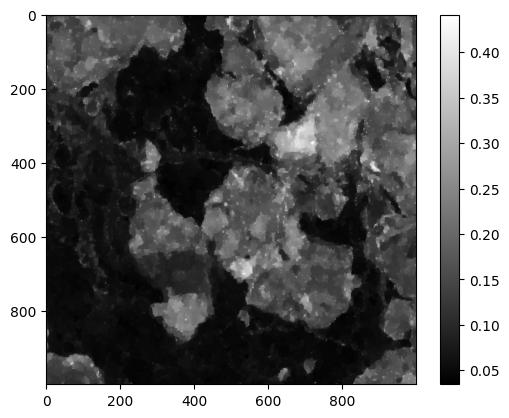

In [127]:
plt.imshow( np.exp(data["x"].reshape((size,size))), cmap="gray" )
plt.colorbar()
plt.show()

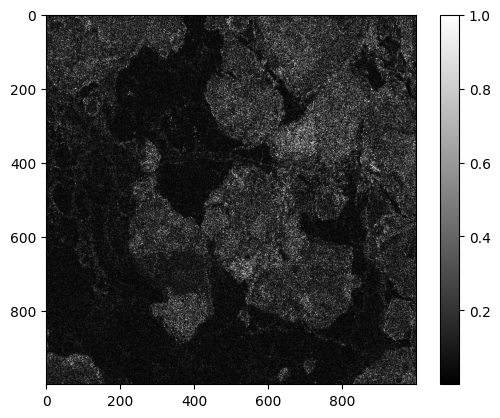

In [124]:
plt.imshow( noisy_signal.reshape((size,size)), cmap="gray" )
plt.colorbar()
plt.show()

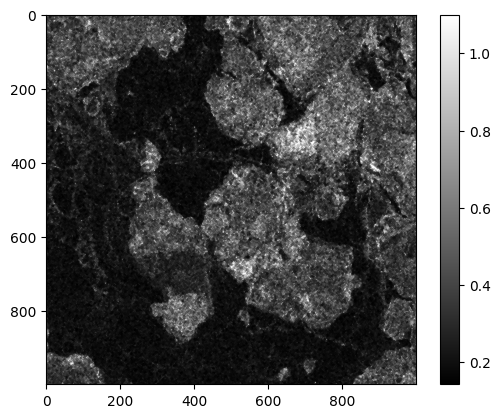

In [125]:
plt.imshow( full_img_lee, cmap="gray" )
plt.colorbar()
plt.show()

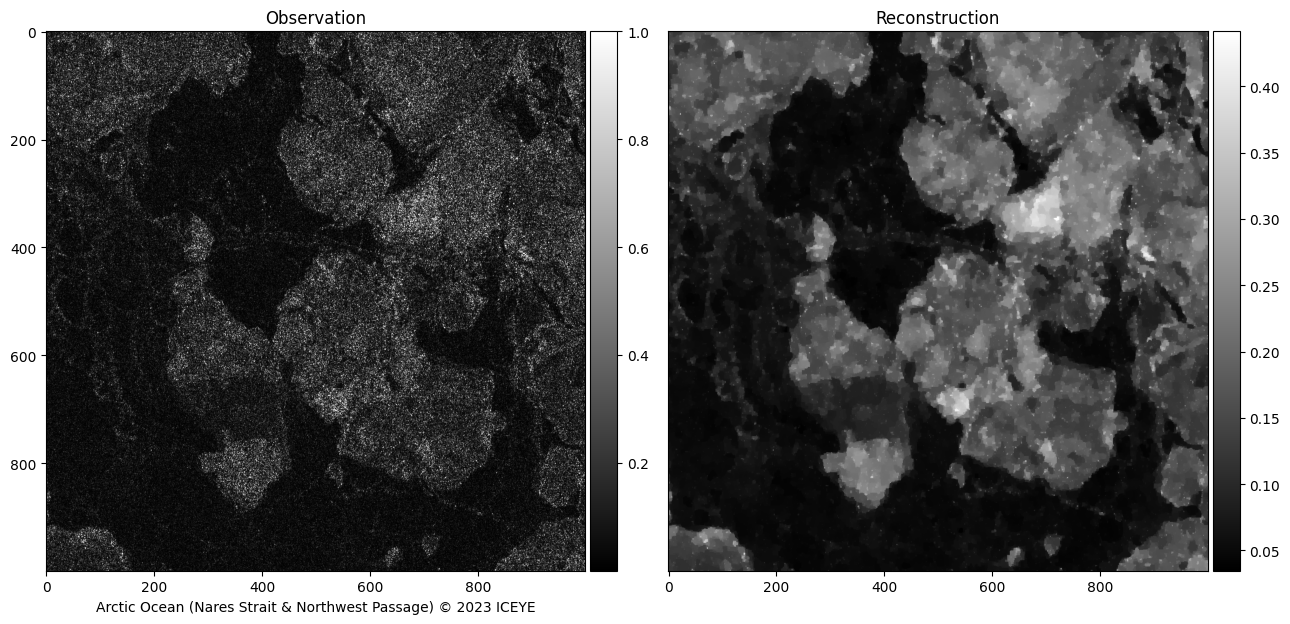

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,2, figsize=(13,8))

# Function to adjust colorbar
def add_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


im1 = axs[0].imshow(  noisy_signal.reshape((size,size)) , cmap="gray")
add_colorbar(im1, axs[0])
axs[0].set_title("Observation")
axs[0].set_xlabel("Arctic Ocean (Nares Strait & Northwest Passage) © 2023 ICEYE") 

im2 = axs[1].imshow( np.exp(data["x"].reshape((size,size))) , cmap="gray")
add_colorbar(im2, axs[1])
axs[1].set_title("Reconstruction")
axs[1].set_yticks([])



# im2 = axs[0,1].imshow(full_img_lee, cmap="gray")
# add_colorbar(im1, axs[0,1])


# im3 = axs[1,0].imshow( np.exp(data["x"].reshape((size,size))) , cmap="gray")
# add_colorbar(im1, axs[1,0])

fig.tight_layout()

fig.savefig("sea_ice_example.png", dpi=400, bbox_inches='tight', pad_inches=0.1)


plt.show()

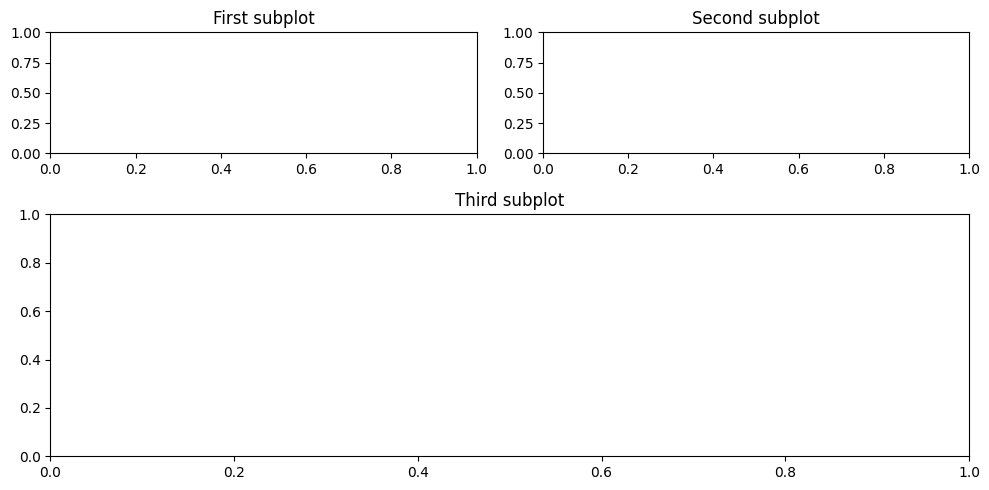

In [131]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 5))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # Adjusted grid size and height_ratios

# First row: two square subplots
ax1 = plt.subplot(gs[0, 0])
ax1.set_title('First subplot')
# (Optionally, add plot details for ax1)

ax2 = plt.subplot(gs[0, 1])
ax2.set_title('Second subplot')
# (Optionally, add plot details for ax2)

# Second row: one large subplot spanning all columns
ax3 = plt.subplot(gs[1, :])  # Spanning all columns
ax3.set_title('Third subplot')
# (Optionally, add plot details for ax3)

# Adjust layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()


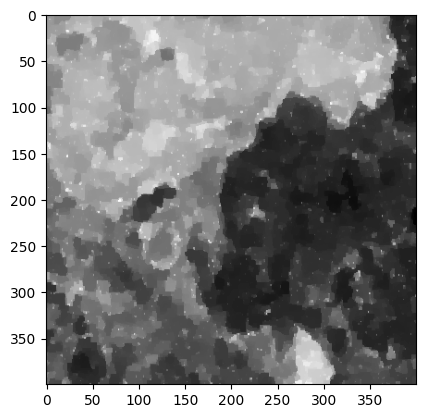

In [116]:
plt.imshow( data["x"].reshape((size,size)), cmap="gray" )
plt.show()

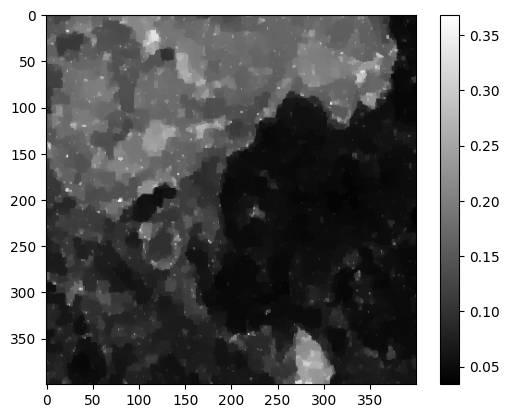

In [117]:
plt.imshow( np.exp(data["x"].reshape((size,size))), cmap="gray" )
plt.colorbar()
plt.show()

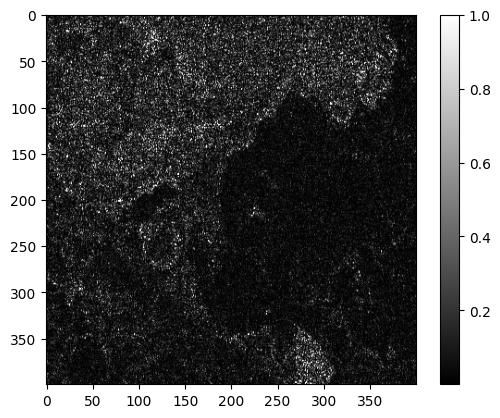

In [118]:
plt.imshow( noisy_signal.reshape((size,size)), cmap="gray" )
plt.colorbar()
plt.show()

# General model

In [107]:

class DespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, A, R, f, hyperparams, L=1, pdata={}):

        # Bind
        self.f = f
        self.R = R
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, u0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if u0 is None:
            u = np.ones(self.n)
        else:
            u = u0
        
        # Handle warmstarting
        if warmstarting:
            u_prev = u.copy()
        else:
            u_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(u)

            # Update u
            u, iters, flag = self.x_update(theta_curr, u0=u_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                u_prev = u.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(u, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "u": u,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, u0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Call projected Newton-Krylov solver
            newton_data = sampi.despeckling_newton_krylov(self.A, self.R, theta, self.L, self.f, u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]



        else:

            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)

            #despeckling_priorconditioned_newton_krylov

            newton_data = sampi.despeckling_priorconditioned_newton_krylov(self.f, self.L, self.A, Rtilde, Rpinv, self.pdata["W"], u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]
          

            # # Build current Rpinv operator
            # Rpinv = self.pdata["Rpinv_factory"](theta)

            # newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            # return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, u):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (u) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, u, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        Au = self.A.matvec(u)
        gamma_likelihood = self.L*(np.log( Au ).sum() + (self.f/Au).sum())
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ u)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gamma_likelihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



In [108]:
# Prior parameters
reg_lambda = 1e-2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-1,
        "vartheta": vartheta,
    },
}

# hyperparams = {
#     "prior": {
#         "r": -1,
#         "beta": 1,
#         "vartheta": 1e-1,
#     },
# }

# Create solver
A = jlinops.IdentityOperator( (R.shape[1], R.shape[1]) )
solver = DespecklingIASSolver(A, R, noisy_signal, hyperparams, L=L, pdata=pdata)

In [111]:
priorconditioning = False
x_update_solver_params = {
    "newton_maxiter": 5,
    "newton_tol": 1e-3,
    "cg_tol": 1e-3,
    "cg_maxiter": None,
    "backtrack_alpha": 0.4,
    "backtrack_beta": 0.95,
    "search_maxiter": 100,
}

# priorconditioning = True
# x_update_solver_params = {
#     "newton_maxiter": 5,
#     "newton_tol": 1e-3,
#     "tol": 1e-8,
#     "maxiter": None,
#     "backtrack_alpha": 0.4,
#     "backtrack_beta": 0.9,
#     "search_maxiter": 100,
# }

data = solver.solve(max_iters=50, u0=noisy_signal, warmstarting=True, eps=1e-4, early_stopping=True,
                    x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

5


/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_71224/2865205753.py:235: RuntimeWarning: invalid value encountered in log
  gamma_likelihood = self.L*(np.log( Au ).sum() + (self.f/Au).sum())


5
5
5
5


KeyboardInterrupt: 

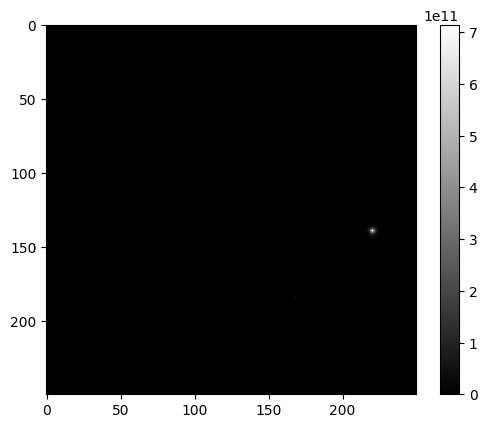

In [93]:
plt.imshow( data["u"].reshape((size,size)), cmap="gray" )
plt.colorbar()
plt.show()